### WA Cities - CSV to JSON

In [18]:
# General dependencies
import pandas as pd
import datetime as dt

# Mapping dependencies
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt

# APIs dependencies
import json
import requests
from pprint import pprint
from resources.api_keys import owm_api_key as owm_key

url_hstr = 'https://api.openweathermap.org/data/2.5/uvi/history?'
units = 'metric'

### CSV to JSON

In [2]:
# Dataframe
city_data_df = pd.read_csv('resources/wa_cities.csv')

# Output to jsom file
city_data_df.to_json('analysis/wa_cities.json')

# Display
city_data_df

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Albany,-35.0228,117.8814,Australia,AU,Western Australia,NaN,34205,29373
1,Augusta,-34.3120,115.1590,Australia,AU,Western Australia,NaN,1109,1109
2,Australind,-33.2792,115.7150,Australia,AU,Western Australia,NaN,14539,14539
3,Bakers Hill,-31.7510,116.4550,Australia,AU,Western Australia,NaN,1118,1118
4,Bentley,-32.0010,115.9240,Australia,AU,Western Australia,NaN,8782,8782
...,...,...,...,...,...,...,...,...,...
78,Wundowie,-31.7667,116.3830,Australia,AU,Western Australia,NaN,1352,1352
79,Yallingup,-33.6397,115.0263,Australia,AU,Western Australia,NaN,1029,1029
80,Yanchep,-31.5500,115.6340,Australia,AU,Western Australia,NaN,8868,8868
81,York,-31.8883,116.7686,Australia,AU,Western Australia,NaN,2548,2535


### Verify positions

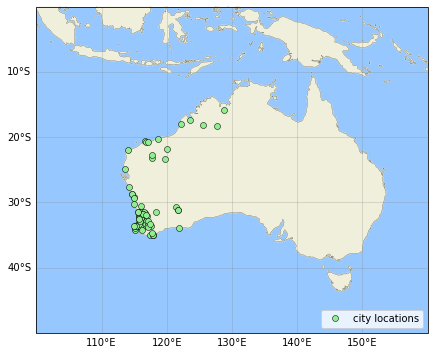

In [3]:
# Display sample cities on a map to verify locations

# Data
x_axis = city_data_df['lng']
y_axis = city_data_df['lat']

# Cartopy base map - https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/geoaxes.html
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,6))
#ax.set_global()  # show maximum extent supported by this projection
ax.set_extent([100, 160, -50, 0], crs=ccrs.PlateCarree())
ax.set_facecolor((150/255, 200/255, 255/255))  # background colour of plot
ax.coastlines(lw=0.2)  # lightly define coastlines
ax.add_feature(cartopy.feature.LAND)  # mask over background with land shape

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False

# Plot city locations
ax.plot(x_axis, y_axis, 'bo', ms=6, mfc='lightgreen', mec='black', mew=0.5, label='city locations')
ax.legend(loc='lower right');


### Collect Historical Data

In [20]:
# Generate grid with timestamps
    
# Empty list to grid locations
grid_list = []

dte_stt = int(dt.datetime.strptime('2020-01-01 12:00:00 UTC', '%Y-%m-%d %H:%M:%S %Z').timestamp())
dte_cnt = 365

for dte in range(dte_stt, dte_stt + dte_cnt*(86400), 86400):
    for latlon in city_data_df.iterrows():

        grid_list.append([latlon[1]['city'], latlon[1]['lat'], latlon[1]['lng'], dte])


print(len(grid_list))
# print(grid_list)

# Partial query URL
qery_url_hstr = f'{url_hstr}&appid={owm_key}'

# Empty variables to hold response
hstr_data_city = {}
hstr_data_city['date'] = []
hstr_data_city['city'] = []
hstr_data_city['latitude'] = []
hstr_data_city['longitude'] = []
hstr_data_city['uv-index'] = []
cntr = 0
# uv index - historical data
# Loop through the grid and perform a request for data on each
# Call function 'grid_pnts' to provide coordinates
for locn in grid_list:  
    
    cntr += 1
    print(f'{cntr} ... {locn} ...')
    
    # If location in OWM database then collect data
    try:
        
        # request uv index data for location
        response = requests.get(qery_url_hstr + '&lat=' + str(locn[1]) + '&lon=' + str(locn[2])  + '&start=' + str(locn[3]) + '&end=' + str(locn[3])).json()
        
        # append to json string
        hstr_data_city['date'].append(dt.datetime.utcfromtimestamp(response[0]['date']).strftime('%Y-%m-%d %H:%M'))
        hstr_data_city['city'].append(locn[0])
        hstr_data_city['latitude'].append(response[0]['lat'])
        hstr_data_city['longitude'].append(response[0]['lon'])
        hstr_data_city['uv-index'].append(response[0]['value'])

        
    # If location not in OWM database then report to log and skip to next location
    except:
        print(f'  {locn} not found ...skipping...')

# write json to file
with open('analysis/hstr_data_city.json', 'w') as outfile:
    json.dump(hstr_data_city, outfile)        

# print to terminal
pprint(hstr_data)
print(f'  Finished data collection')

166
1 ... ['Albany', -35.0228, 117.8814, 1577851200] ...
2 ... ['Augusta', -34.312, 115.15899999999999, 1577851200] ...
3 ... ['Australind', -33.2792, 115.715, 1577851200] ...
4 ... ['Bakers Hill', -31.750999999999998, 116.455, 1577851200] ...
5 ... ['Bentley', -32.001, 115.92399999999999, 1577851200] ...
6 ... ['Beverley', -32.109, 116.926, 1577851200] ...
7 ... ['Bindoon', -31.38, 116.09700000000001, 1577851200] ...
8 ... ['Binningup', -33.149, 115.689, 1577851200] ...
9 ... ['Boddington', -32.802, 116.471, 1577851200] ...
10 ... ['Boyanup', -33.4861, 115.73, 1577851200] ...
11 ... ['Bridgetown', -33.9583, 116.1381, 1577851200] ...
12 ... ['Broome', -17.9619, 122.2361, 1577851200] ...
13 ... ['Bullsbrook', -31.663, 116.03, 1577851200] ...
14 ... ['Bunbury', -33.3333, 115.6333, 1577851200] ...
15 ... ['Busselton', -33.6478, 115.3458, 1577851200] ...
16 ... ['Cannington', -32.0167, 115.95, 1577851200] ...
17 ... ['Capel', -33.556999999999995, 115.57, 1577851200] ...
18 ... ['Carnarvon'

145 ... ['Nullagine', -21.888, 120.10700000000001, 1577937600] ...
146 ... ['Paraburdoo', -23.201, 117.671, 1577937600] ...
147 ... ['Perth', -31.9522, 115.8589, 1577937600] ...
148 ... ['Pinjarra', -32.63, 115.8711, 1577937600] ...
149 ... ['Port Denison', -29.2833, 114.9167, 1577937600] ...
150 ... ['Port Hedland', -20.31, 118.6011, 1577937600] ...
151 ... ['Quindalup', -33.6671, 115.1451, 1577937600] ...
152 ... ['Ravenswood', -32.5833, 115.833, 1577937600] ...
153 ... ['Serpentine', -32.365, 115.98100000000001, 1577937600] ...
154 ... ['Tom Price', -22.6939, 117.795, 1577937600] ...
155 ... ['Toodyay', -31.55, 116.45, 1577937600] ...
156 ... ['Two Rocks', -31.495, 115.588, 1577937600] ...
157 ... ['Vasse', -33.69, 115.3, 1577937600] ...
158 ... ['Wagin', -33.3167, 117.35, 1577937600] ...
159 ... ['Waroona', -32.8667, 115.9167, 1577937600] ...
160 ... ['Wickham', -20.675, 117.1403, 1577937600] ...
161 ... ['Wooroloo', -31.803, 116.314, 1577937600] ...
162 ... ['Wundowie', -31.7667, 

NameError: name 'hstr_data' is not defined

In [22]:
# Dataframe
hstr_data_city_df = pd.read_json('analysis/hstr_data_city.json')

# Output to CSV file
hstr_data_city_df.to_csv('analysis/hstr_data_city.csv', index=False)

# Display
hstr_data_city_df

,date,city,latitude,longitude,uv-index
0,2020-01-01 12:00:00,Albany,-35.0228,117.8814,12.58
1,2020-01-01 12:00:00,Augusta,-34.3120,115.1590,12.96
2,2020-01-01 12:00:00,Australind,-33.2792,115.7150,13.22
3,2020-01-01 12:00:00,Bakers Hill,-31.7510,116.4550,13.66
4,2020-01-01 12:00:00,Bentley,-32.0010,115.9240,13.32
...,...,...,...,...,...
161,2020-01-02 12:00:00,Wundowie,-31.7667,116.3830,13.78
162,2020-01-02 12:00:00,Yallingup,-33.6397,115.0263,12.51
163,2020-01-02 12:00:00,Yanchep,-31.5500,115.6340,13.37
164,2020-01-02 12:00:00,York,-31.8883,116.7686,13.93
